# Study on the IRIS DataBase

if the package POT is not already installed on ur computer, use "pip install pot"

## Import

In [3]:
import numpy as np
import ot
import pandas as pd

import matplotlib.pyplot as plt
# import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from tqdm import tqdm

import geopandas as gpd



df = pd.read_csv('BASE_TD_FILO_DEC_IRIS_2020.csv', sep=';', decimal=',')

# Main numerical variables
numerical_cols = df.select_dtypes(include=['number']).columns

# Decile columns
decile_cols = ['DEC_D120', 'DEC_D220', 'DEC_D320', 'DEC_D420', 'DEC_MED20', 'DEC_D620', 'DEC_D720', 'DEC_D820', 'DEC_D920']

# Convert from object to float64
df[decile_cols] = df[decile_cols].apply(pd.to_numeric, errors='coerce')

# Remove the 1319 rows with missing deciles
df_clean = df.dropna(subset=decile_cols + ['DEC_MED20']).reset_index(drop=True)

# Support of the deciles 
support = np.arange(1, 10)  # D1 to D9

# Colors used for visualization
colors = ['blue', 'green', 'red', 'orange', 'purple', 'brown', 'pink']


Data preview:
        IRIS DEC_PIMP20 DEC_TP6020 DEC_Q120  DEC_MED20 DEC_Q320 DEC_EQ20  \
0  010040101       41,8       32,7    10940    18240.0    24950     0,77   
1  010040102       39,0       41,1     9010    15860.0    23660     0,92   
2  010040201       45,6       29,2    11700    19130.0    27000     0,80   
3  010040202       59,8       14,0    17500    24790.0    33710     0,65   
4  010330102       39,1       30,6    11100    19090.0    29590     0,97   

   DEC_D120  DEC_D220  DEC_D320  ...  DEC_RD20  DEC_S80S2020  DEC_GI20  \
0    6220.0    9630.0   12440.0  ...       5,3           6,8     0,328   
1    4030.0    7750.0   10150.0  ...       7,8           9,7     0,370   
2    6150.0   10030.0   13260.0  ...       5,7           7,6     0,342   
3   10820.0   15850.0   19050.0  ...       4,1           5,5     0,317   
4    4930.0    9220.0   12910.0  ...       8,6          10,7     0,391   

   DEC_PACT20  DEC_PTSA20 DEC_PCHO20 DEC_PBEN20 DEC_PPEN20 DEC_PAUT20  \
0        68

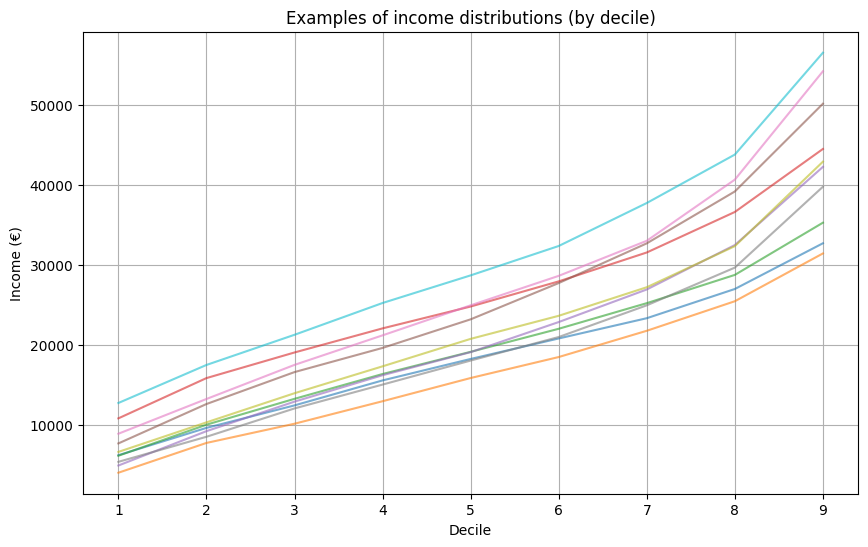

In [4]:
# Overview of the data
print("Data preview:")
print(df_clean.head())

print("\nGeneral information:")
print(df_clean.info())

print("\nDescriptive statistics:")
print(df_clean.describe())

# Plot of few IRIS deciles
plt.figure(figsize=(10, 6))
for i in range(10):
    plt.plot(support, df_clean.loc[i, decile_cols], alpha=0.6)
plt.title("Examples of income distributions (by decile)")
plt.xlabel("Decile")
plt.ylabel("Income (€)")
plt.grid(True)
plt.show()


## Barycenters with Wasserstein

In [5]:
# Parameters
n_iter = 20
a = np.ones(len(support)) / len(support)

# Normalization
distributions_raw = df_clean[decile_cols].to_numpy()
distributions = distributions_raw / distributions_raw.sum(axis=1, keepdims=True)
n_distributions = distributions.shape[0]


def wbarycenters(k, n_iter, a, distributions, support):
    n_distributions = distributions.shape[0]
    
    assignments = np.random.choice(k, size=n_distributions) # Random initial assignment

    for it in range(n_iter):
        # Computation of barycenters
        barycenters = []
        for j in range(k):
            members = distributions[assignments == j]
            if len(members) == 0:
                # Empty cluster: sample a random distribution
                barycenters.append(distributions[np.random.randint(n_distributions)])
            else:
                barycenters.append(np.mean(members, axis=0))  # 1D barycenter = mean

        # Reassignement
        new_assignments = np.zeros(n_distributions, dtype=int)
        for i in range(n_distributions):
            dists = [ot.wasserstein_1d(support, support, distributions[i], bary) for bary in barycenters]
            new_assignments[i] = np.argmin(dists)

        assignments = new_assignments
    return assignments, barycenters


### Elbow Method

In [15]:
k_values = range(1, 11)

inertias = []
for k_test in tqdm(k_values):
    assignments, barycenters = wbarycenters(k_test, n_iter, a, distributions, support)
    inertia = 0
    for i in range(n_distributions):
        bary = barycenters[assignments[i]]
        inertia += ot.wasserstein_1d(support, support, distributions[i], bary)
    inertias.append(inertia)


100%|██████████| 10/10 [56:00<00:00, 336.08s/it]


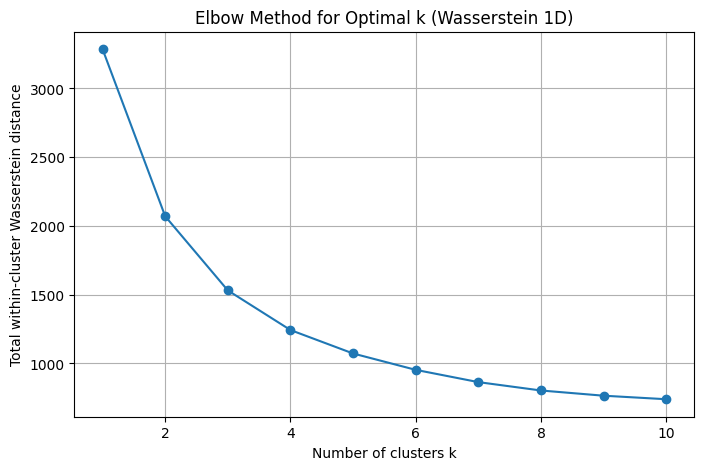

In [16]:
plt.figure(figsize=(8, 5))
plt.plot(k_values, inertias, marker='o')
plt.title("Elbow Method for Optimal k (Wasserstein 1D)")
plt.xlabel("Number of clusters k")
plt.ylabel("Total within-cluster Wasserstein distance")
plt.grid(True)
plt.show()


We observe a rapid decrease in the total within-cluster Wasserstein distance between *k* = 1 and *k* = 4.

From *k* = 5 onward, the curve appears to flatten. The classic elbow seems to be located around *k* = 4

### Barycenters plot

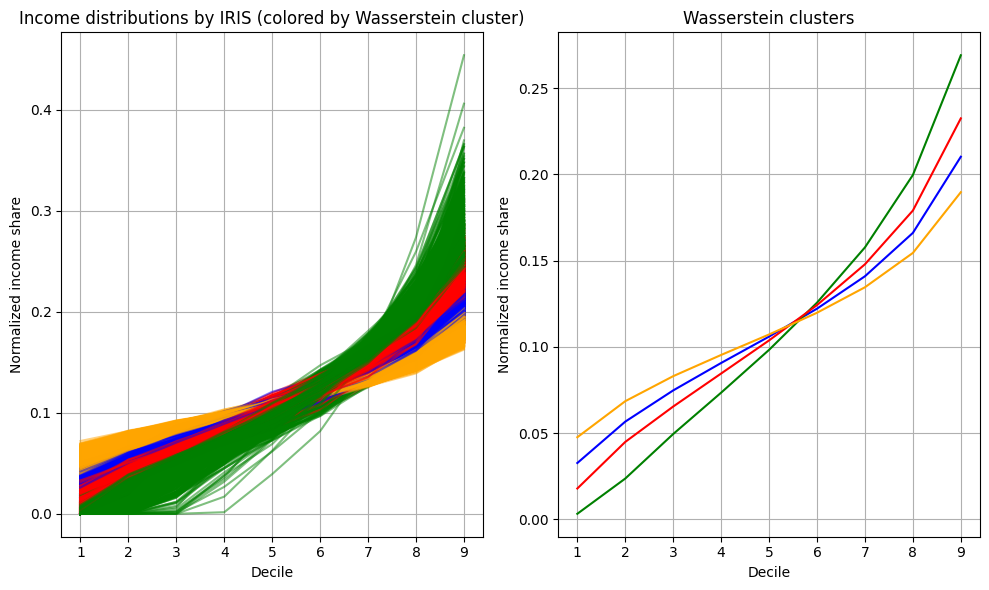

In [6]:
k = 4

assignments, barycenters = wbarycenters(k, n_iter, a, distributions, support)
df_clean["cluster_wasserstein_1d"] = assignments


plt.figure(figsize=(10, 6))

# Plot all distributions 
plt.subplot(1, 2, 1)
for i in range(n_distributions):
    cluster = assignments[i]
    plt.plot(support, distributions[i], color=colors[cluster % len(colors)], alpha=0.5)

plt.title("Income distributions by IRIS (colored by Wasserstein cluster)")
plt.xlabel("Decile")
plt.ylabel("Normalized income share")
plt.grid(True)

# Plot Barycenters
plt.subplot(1, 2, 2)
for i in range(len(barycenters)):
    plt.plot(support, barycenters[i], color=colors[i % len(colors)])
plt.title("Wasserstein clusters")
plt.xlabel("Decile")
plt.ylabel("Normalized income share")
plt.grid(True)

plt.tight_layout()
plt.show()


### PCA Projection

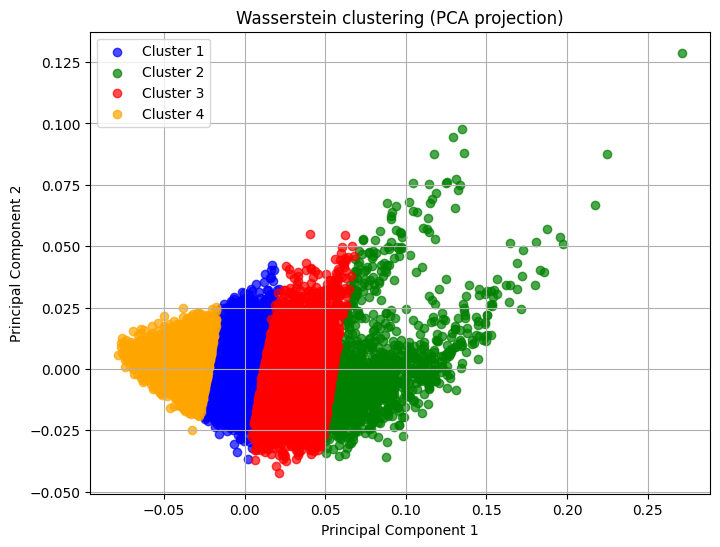

In [7]:
pca = PCA(n_components=2)
proj = pca.fit_transform(distributions)

plt.figure(figsize=(8, 6))
for i in range(k):
    plt.scatter(proj[assignments == i, 0], proj[assignments == i, 1], color=colors[i], label=f'Cluster {i+1}', alpha=0.7)

plt.title("Wasserstein clustering (PCA projection)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.grid(True)
plt.show()


## Comparison with a KMeans based on the median

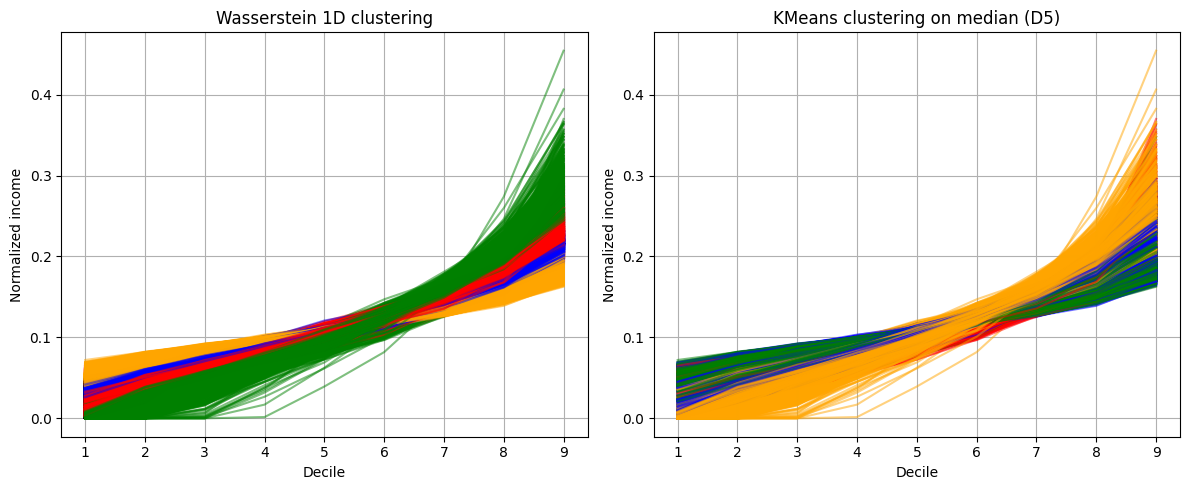

In [8]:
# Computation
kmeans_median = KMeans(n_clusters=k, n_init="auto", random_state=0)
df_clean["cluster_median"] = kmeans_median.fit_predict(df_clean[["DEC_MED20"]])


# Comparison

plt.figure(figsize=(12, 5))

# Wasserstein clustering
plt.subplot(1, 2, 1)
for i in range(n_distributions):
    cluster = assignments[i]
    plt.plot(support, distributions[i], color=colors[cluster % len(colors)], alpha=0.5)
plt.title("Wasserstein 1D clustering")
plt.xlabel("Decile")
plt.ylabel("Normalized income")
plt.grid(True)

# KMeans on median
plt.subplot(1, 2, 2)
for i in range(n_distributions):
    cluster = df_clean["cluster_median"].iloc[i]
    plt.plot(support, distributions[i], color=colors[cluster % len(colors)], alpha=0.5)
plt.title("KMeans clustering on median (D5)")
plt.xlabel("Decile")
plt.ylabel("Normalized income")
plt.grid(True)

plt.tight_layout()
plt.show()


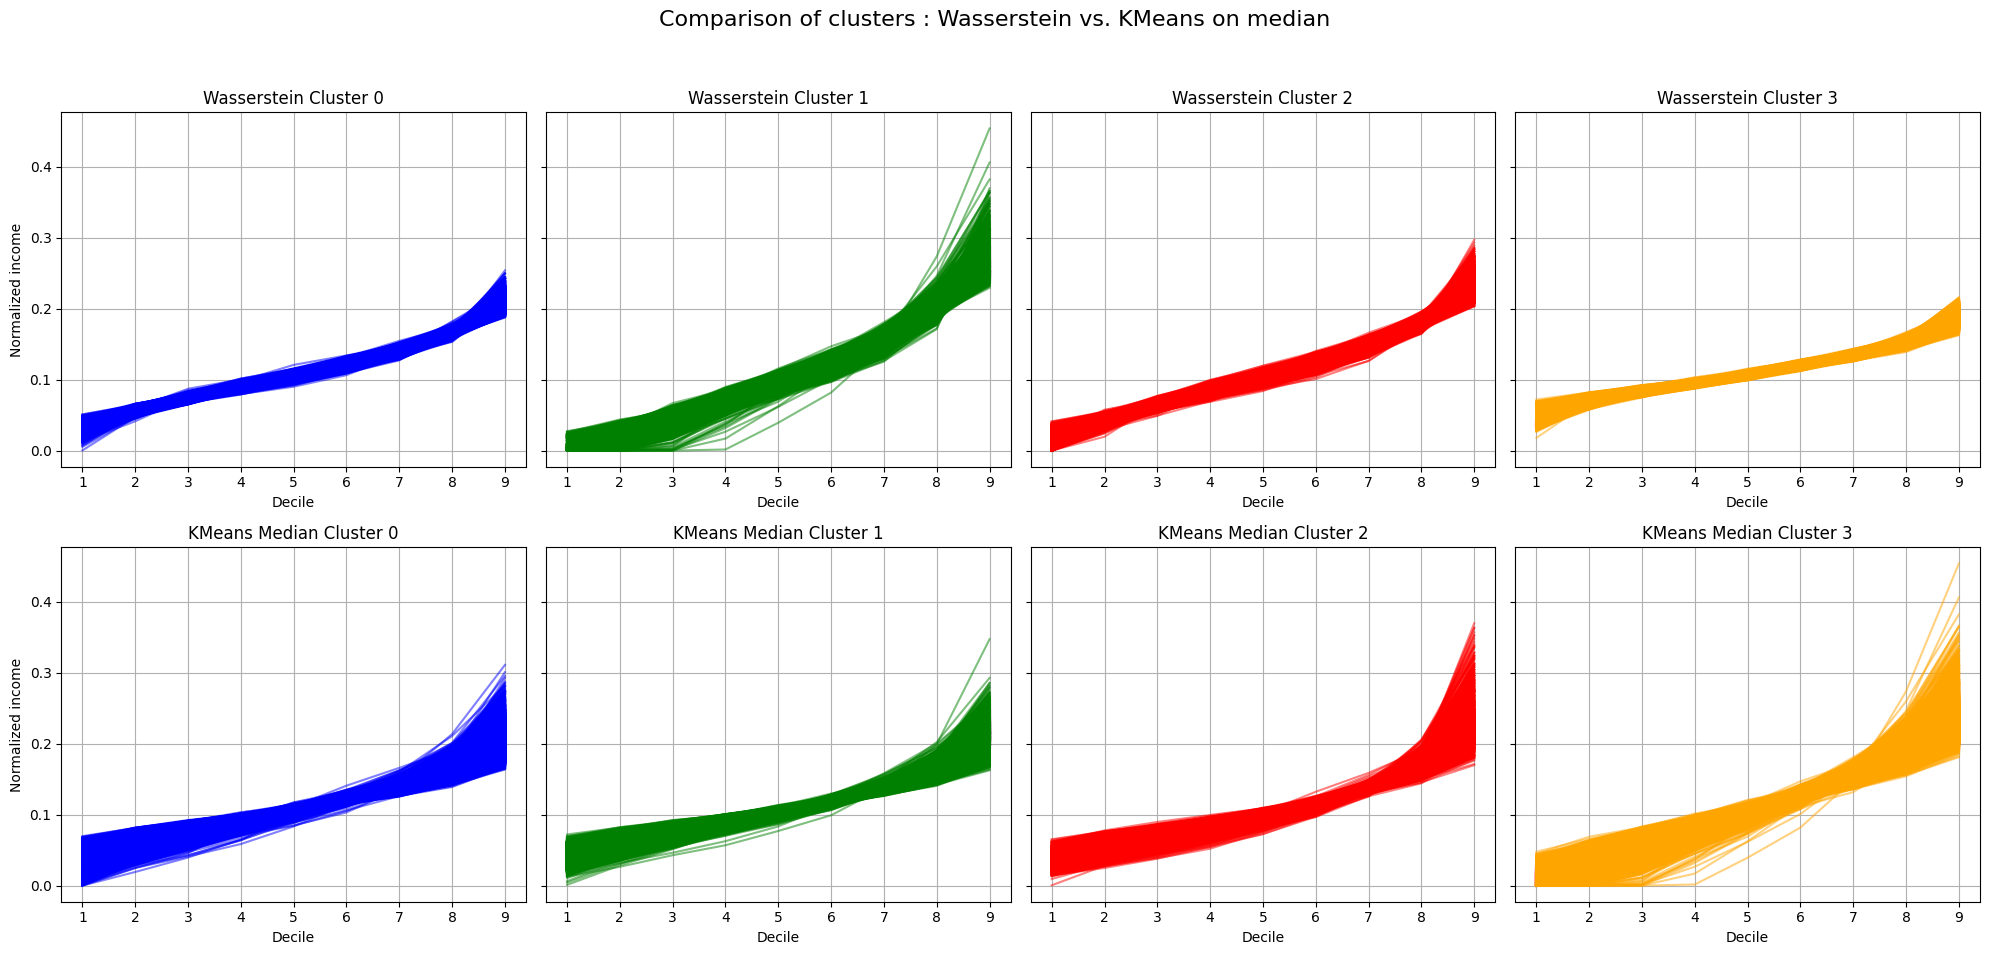

In [9]:
fig, axes = plt.subplots(2, 4, figsize=(20, 10), sharey=True)
fig.suptitle("Comparison of clusters : Wasserstein vs. KMeans on median", fontsize=16)

# Wasserstein clusters
for cluster_id in range(k):
    ax = axes[0, cluster_id]
    members = distributions[df_clean["cluster_wasserstein_1d"] == cluster_id]
    for dist in members:
        ax.plot(support, dist, color=colors[cluster_id % len(colors)], alpha=0.5)
    ax.set_title(f"Wasserstein Cluster {cluster_id}")
    ax.set_xlabel("Decile")
    if cluster_id == 0:
        ax.set_ylabel("Normalized income")
    ax.grid(True)

# KMeans on median clusters
for cluster_id in range(k):
    ax = axes[1, cluster_id]
    members = distributions[df_clean["cluster_median"] == cluster_id]
    for dist in members:
        ax.plot(support, dist, color=colors[cluster_id % len(colors)], alpha=0.5)
    ax.set_title(f"KMeans Median Cluster {cluster_id}")
    ax.set_xlabel("Decile")
    if cluster_id == 0:
        ax.set_ylabel("Normalized income")
    ax.grid(True)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


### Wasserstein vs Kmeans PCA version

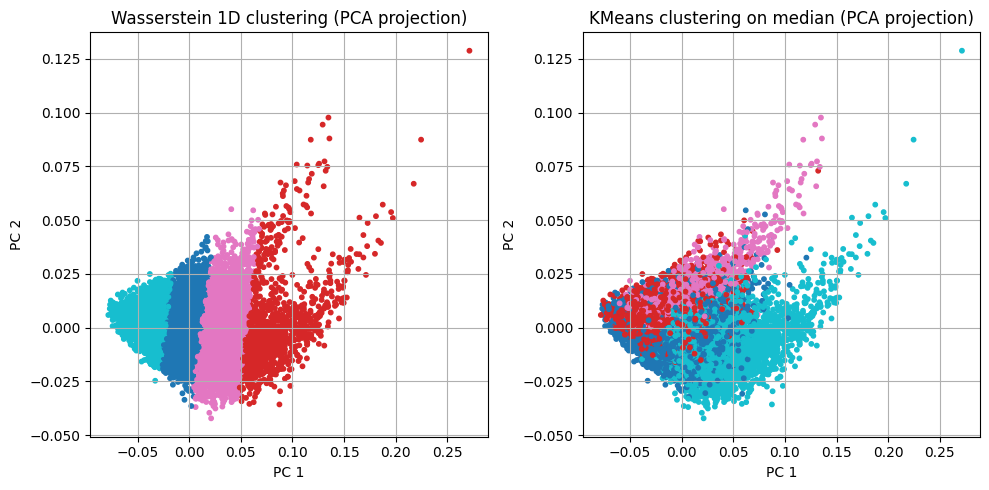

In [10]:
# Comparison
plt.figure(figsize=(10, 5))

# Wasserstein
plt.subplot(1, 2, 1)
plt.scatter(proj[:, 0], proj[:, 1], c=df_clean["cluster_wasserstein_1d"], cmap="tab10", s=10)
plt.title("Wasserstein 1D clustering (PCA projection)")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.grid(True)

# KMeans on median
plt.subplot(1, 2, 2)
plt.scatter(proj[:, 0], proj[:, 1], c=df_clean["cluster_median"], cmap="tab10", s=10)
plt.title("KMeans clustering on median (PCA projection)")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.grid(True)

plt.tight_layout()
plt.show()


## Mapping

In [49]:
# Load IRIS boundaries
gdf_iris = gpd.read_file("contours-iris.gpkg")


La colonne 'code_iris' contient les codes de sous iris, il faut les fusionner pour pouvoir merge avec df_clean

In [50]:
# Recalculer la colonne IRIS_base
gdf_iris['IRIS_base'] = gdf_iris['code_iris'].astype(str).str[:9]
df_clean['IRIS'] = df_clean['IRIS'].astype(str)

# Merge "à la main" sur les identifiants de base
gdf = gdf_iris.merge(df_clean, left_on='IRIS_base', right_on='IRIS', how='left')

In [65]:
df_clean['IRIS'][10000]

'763512501'

In [66]:
txt = "763512501"  # remplace par le motif que tu cherches
matches = gdf_iris[gdf_iris['code_iris'].astype(str).str.contains(txt, na=False)]

print(matches['code_iris'])

14604    763512501
Name: code_iris, dtype: object


In [67]:
non_associes = gdf_iris[~gdf_iris['code_iris'].astype(str).str[:9].isin(df_clean['IRIS'].astype(str))]
print(non_associes['code_iris'].unique())
print(f"Nombre de code_iris sans correspondance : {len(non_associes)}")


['670430101' '561850101' '930630101' ... '629060000' '596680000'
 '596690000']
Nombre de code_iris sans correspondance : 34265


In [70]:
lengths = df_clean['IRIS'].astype(str).str.len()
print("Longueurs uniques dans code_iris :", lengths.unique())

Longueurs uniques dans code_iris : [9]


In [53]:
# Nombre de polygones associés à chaque IRIS
matches = gdf[gdf['DEC_MED20'].notna()]
grouped = matches.groupby('IRIS')['code_iris'].nunique().sort_values(ascending=False)
print(grouped.head(10))


IRIS
010040101    1
010040102    1
010040201    1
010040202    1
010330102    1
010330103    1
010330201    1
010330202    1
010330301    1
010330401    1
Name: code_iris, dtype: int64


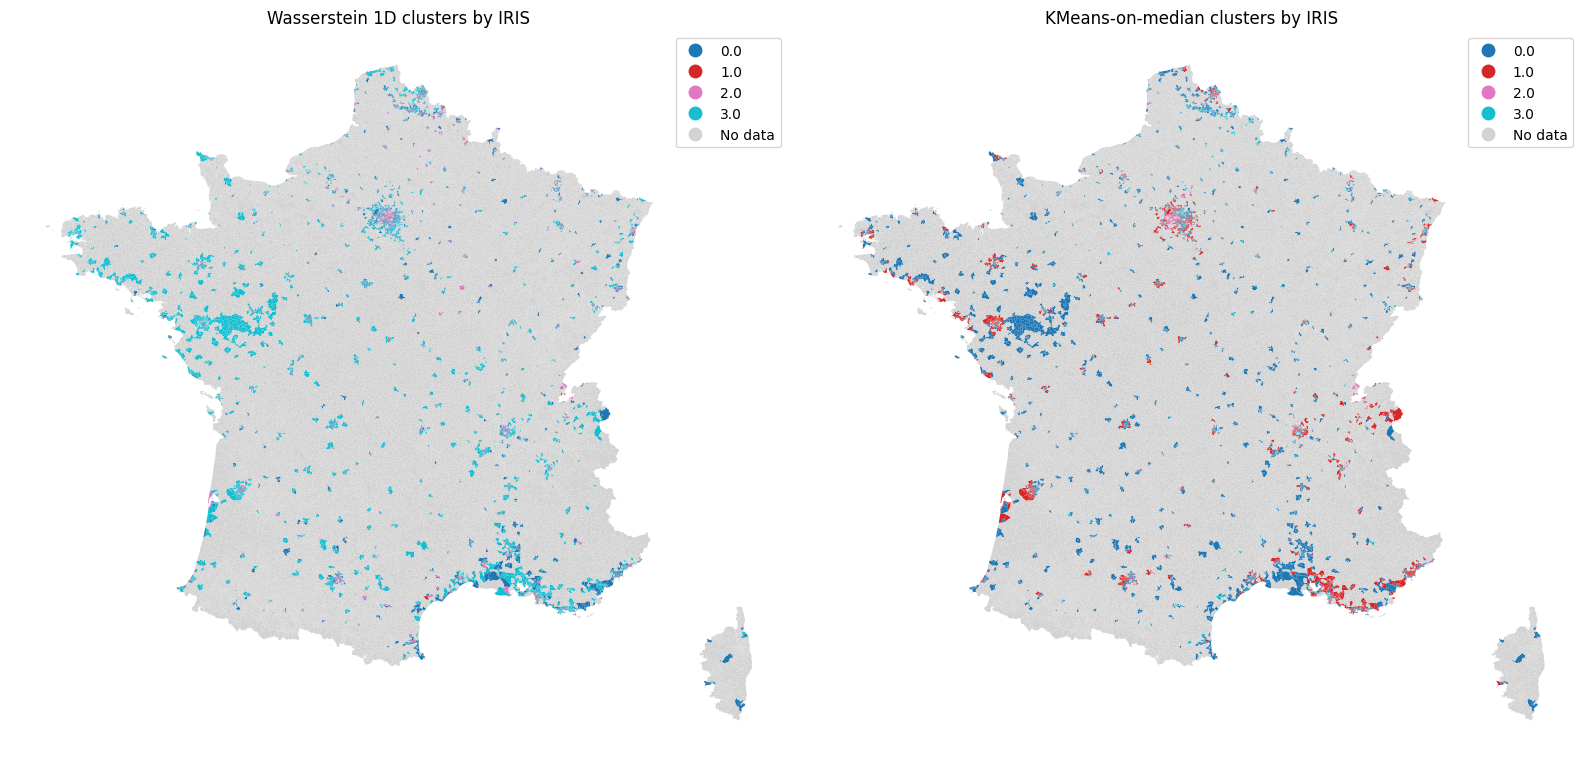

In [51]:
# Convert clusters to categorical type for correct coloring and legend
gdf['cluster_wasserstein_1d'] = gdf['cluster_wasserstein_1d'].astype('category')
gdf['cluster_median'] = gdf['cluster_median'].astype('category')

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Wasserstein clusters
gdf.plot(
    column='cluster_wasserstein_1d',
    cmap='tab10',
    categorical=True,       # Important for categorical coloring
    legend=True,
    ax=axes[0],
    missing_kwds={'color': 'lightgrey', 'label': 'No data'}
)
axes[0].set_title("Wasserstein 1D clusters by IRIS")
axes[0].axis('off')

# KMeans on median clusters
gdf.plot(
    column='cluster_median',
    cmap='tab10',
    categorical=True,       # Important for categorical coloring
    legend=True,
    ax=axes[1],
    missing_kwds={'color': 'lightgrey', 'label': 'No data'}
)
axes[1].set_title("KMeans-on-median clusters by IRIS")
axes[1].axis('off')

plt.tight_layout()
plt.show()


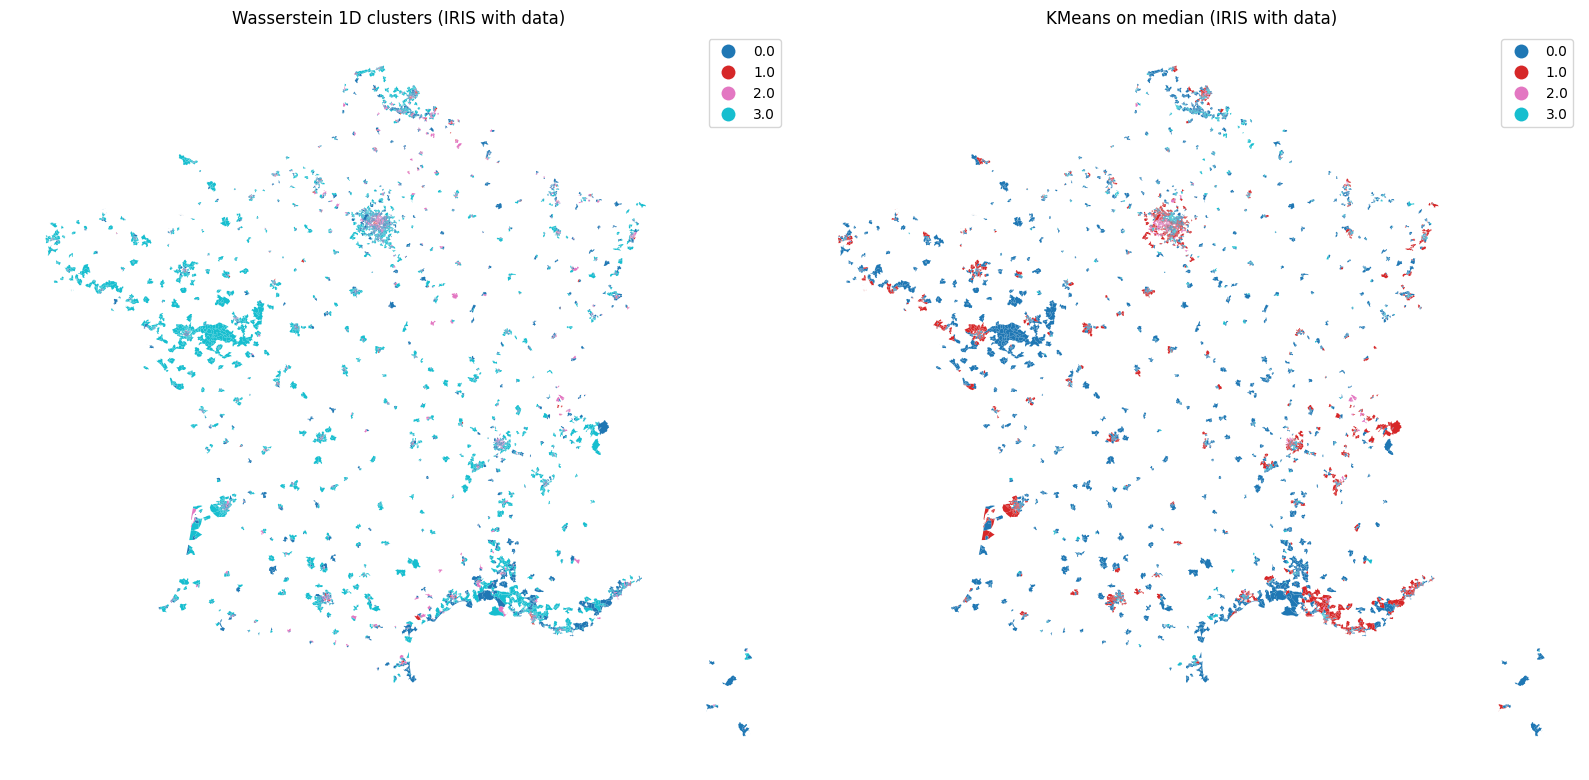

In [23]:
gdf_with_data = gdf.dropna(subset=['cluster_wasserstein_1d', 'cluster_median'])

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Wasserstein
gdf_with_data.plot(
    column='cluster_wasserstein_1d',
    cmap='tab10',
    legend=True,
    ax=axes[0]
)
axes[0].set_title("Wasserstein 1D clusters (IRIS with data)")
axes[0].axis('off')

# KMeans
gdf_with_data.plot(
    column='cluster_median',
    cmap='tab10',
    legend=True,
    ax=axes[1]
)
axes[1].set_title("KMeans on median (IRIS with data)")
axes[1].axis('off')

plt.tight_layout()
plt.show()


In [24]:
print("Unique values per column in gdf:")
print(gdf.nunique())

print("\nUnique values per column in df_clean:")
print(df_clean.nunique())


Unique values per column in gdf:
cleabs                    48569
code_insee                34848
nom_commune               32625
iris                       1174
code_iris                 48569
nom_iris                  42436
type_iris                     4
geometry                  48569
IRIS                      14304
cluster_wasserstein_1d        4
cluster_median                4
dtype: int64

Unique values per column in df_clean:
IRIS                      14706
DEC_PIMP20                  747
DEC_TP6020                  764
DEC_Q120                   2695
DEC_MED20                  3450
DEC_Q320                   4294
DEC_EQ20                    198
DEC_D120                   1872
DEC_D220                   2481
DEC_D320                   2854
DEC_D420                   3138
DEC_D620                   3736
DEC_D720                   4069
DEC_D820                   4522
DEC_D920                   5425
DEC_RD20                    904
DEC_S80S2020                942
DEC_GI20           

In [27]:
df_clean.columns

Index(['IRIS', 'DEC_PIMP20', 'DEC_TP6020', 'DEC_Q120', 'DEC_MED20', 'DEC_Q320',
       'DEC_EQ20', 'DEC_D120', 'DEC_D220', 'DEC_D320', 'DEC_D420', 'DEC_D620',
       'DEC_D720', 'DEC_D820', 'DEC_D920', 'DEC_RD20', 'DEC_S80S2020',
       'DEC_GI20', 'DEC_PACT20', 'DEC_PTSA20', 'DEC_PCHO20', 'DEC_PBEN20',
       'DEC_PPEN20', 'DEC_PAUT20', 'DEC_NOTE20', 'cluster_wasserstein_1d',
       'cluster_median'],
      dtype='object')